In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import inv_boxcox
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

In [2]:
dataPath = '../data/TfL dataset.xlsx'
veh1 = pd.read_excel(dataPath,sheet_name='veh.1')
veh1 = veh1.loc[:, ~veh1.columns.str.contains('^Unnamed')]
veh1.drop(veh1.index[0],inplace=True)
# veh1.drop(['Eng. Speed'],axis=1,inplace=True)

In [3]:
veh1.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle
1,0.1,0.056133,872.34,0,0.000004,0.32878,Urban-Free
2,1.1,0.019722,871.085,0,0.000004,0.332906,Urban-Free
3,2.1,0.046526,868.51,0,0.000004,0.331826,Urban-Free
4,3.1,0.035399,874.915,0,0.000005,0.326944,Urban-Free
5,4.1,0.049053,866.438,0,0.000002,0.324458,Urban-Free


In [4]:
veh1.shape

(14019, 7)

In [5]:
veh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 1 to 14019
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Test Time       14019 non-null  object
 1   Roll Speed      14019 non-null  object
 2   Eng. Speed      14019 non-null  object
 3   CO Mass         14019 non-null  object
 4   NOx Mass        14019 non-null  object
 5   CO2 Mass        14019 non-null  object
 6   driving cycle   14019 non-null  object
dtypes: object(7)
memory usage: 876.2+ KB


there are no missing values in the dataset 

In [6]:
columns = veh1.columns
for col in columns:
    if col == 'driving cycle ':
        continue
    else:
        veh1[col] = veh1[col].astype('float')

In [7]:
veh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 1 to 14019
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Test Time       14019 non-null  float64
 1   Roll Speed      14019 non-null  float64
 2   Eng. Speed      14019 non-null  float64
 3   CO Mass         14019 non-null  float64
 4   NOx Mass        14019 non-null  float64
 5   CO2 Mass        14019 non-null  float64
 6   driving cycle   14019 non-null  object 
dtypes: float64(6), object(1)
memory usage: 876.2+ KB


# Considering only one driving mode

In [8]:
# Considering only the urban free flow
uFree = veh1[veh1['driving cycle ']=='Urban-Free']
assert len(list(uFree['driving cycle '].unique()))==1
uFree.drop(['driving cycle '],axis=1,inplace=True)
uFree.head()

In [9]:
sns.pairplot(uFree)

NameError: name 'uFree' is not defined

<AxesSubplot:>

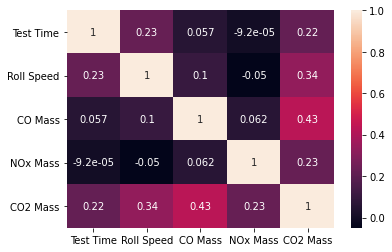

In [10]:
corr = uFree.corr()
sns.heatmap(corr,annot=True)

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(uFree[['Test Time','Roll Speed']].values,uFree[['CO Mass','NOx Mass','CO2 Mass']].values,shuffle=False,test_size=0.2)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (961, 2),xtest shape is (241, 2)
ytrain shape is (961, 3),ytest shape is (241, 3)


In [12]:
scaler = MinMaxScaler()
scaler.fit(xtrain)
xtrainScaled = scaler.transform(xtrain)
xtestScaled = scaler.transform(xtest)

xtrainScaled = xtrainScaled.reshape(xtrainScaled.shape[0],1,xtrainScaled.shape[1])
xtestScaled = xtestScaled.reshape(xtestScaled.shape[0],1,xtestScaled.shape[1])

print(f'xtrain shape is {xtrainScaled.shape},xtest shape is {xtestScaled.shape}')

xtrain shape is (961, 1, 2),xtest shape is (241, 1, 2)


In [69]:
# Basic LSTM model

model = keras.Sequential()
model.add(keras.layers.LSTM(8,return_sequences=True,input_shape=(xtrainScaled.shape[1],xtrainScaled.shape[2])))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3))

model.compile(loss='mae',metrics=['mse'],optimizer='adam')

In [70]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 8)              352       
_________________________________________________________________
dense_20 (Dense)             (None, 1, 4)              36        
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 4)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 15        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(xtrainScaled,ytrain,validation_split=0.05,batch_size=32,epochs=200)

=================] - 0s 2ms/step - loss: 0.1066 - mse: 0.0752 - val_loss: 0.1898 - val_mse: 0.2085
Epoch 51/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1081 - mse: 0.0781 - val_loss: 0.1900 - val_mse: 0.2090
Epoch 52/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1169 - mse: 0.0843 - val_loss: 0.1895 - val_mse: 0.2116
Epoch 53/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1166 - mse: 0.0828 - val_loss: 0.1894 - val_mse: 0.2110
Epoch 54/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1135 - mse: 0.0844 - val_loss: 0.1891 - val_mse: 0.2087
Epoch 55/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1123 - mse: 0.0805 - val_loss: 0.1895 - val_mse: 0.2093
Epoch 56/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1149 - mse: 0.0860 - val_loss: 0.1891 - val_mse: 0.2116
Epoch 57/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1091 - mse: 0.0777 - val_loss: 0.

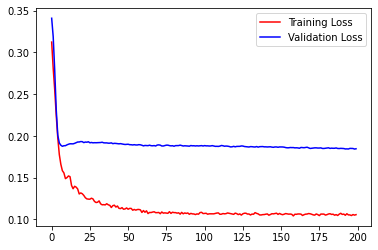

In [72]:
plt.plot(history.history['loss'],color='r',label='Training Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [73]:
predictions = model.predict(xtestScaled)
print(predictions.shape)

(241, 3)


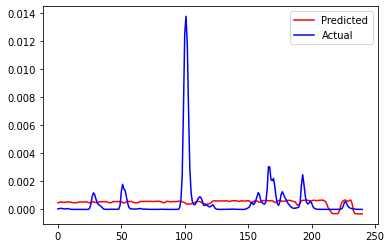

In [74]:
plt.plot(predictions[:,0],color='r',label='Predicted')
plt.plot(ytest[:,0],color='b',label='Actual')
plt.legend()
plt.show()

# Considering all the driving cycles

In [8]:
dataPath = '../data/TfL dataset.xlsx'
veh1 = pd.read_excel(dataPath,sheet_name='veh.1')
veh1 = veh1.loc[:, ~veh1.columns.str.contains('^Unnamed')]
veh1.drop(veh1.index[0],inplace=True)
veh1.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle
1,0.1,0.056133,872.34,0,0.000004,0.32878,Urban-Free
2,1.1,0.019722,871.085,0,0.000004,0.332906,Urban-Free
3,2.1,0.046526,868.51,0,0.000004,0.331826,Urban-Free
4,3.1,0.035399,874.915,0,0.000005,0.326944,Urban-Free
5,4.1,0.049053,866.438,0,0.000002,0.324458,Urban-Free


In [9]:
xtrain,xtest,ytrain,ytest = train_test_split(veh1[['Roll Speed','Eng. Speed','driving cycle ']].values,
                                            veh1[['CO Mass','NOx Mass','CO2 Mass']].values, test_size=0.2,shuffle=True,random_state=42)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (11215, 3),xtest shape is (2804, 3)
ytrain shape is (11215, 3),ytest shape is (2804, 3)


In [12]:
scaler = MinMaxScaler()
scaler.fit(xtrain[:,:-1])
xtrainScaled = scaler.transform(xtrain[:,:-1])
xtestScaled = scaler.transform(xtest[:,:-1])

xtrainScaled = xtrainScaled.reshape(xtrainScaled.shape[0],1,xtrainScaled.shape[1])
xtestScaled = xtestScaled.reshape(xtestScaled.shape[0],1,xtestScaled.shape[1])

print(f'xtrain shape is {xtrainScaled.shape},xtest shape is {xtestScaled.shape}')

embedding_size = int(min(50,veh1['driving cycle '].nunique()+1/2))
print(embedding_size)

xtrain shape is (11215, 1, 2),xtest shape is (2804, 1, 2)
9


In [13]:
# categorical variable 
cat_input = keras.layers.Input(shape=(1,))
embed = keras.layers.Embedding(veh1['driving cycle '].nunique(),embedding_size)(cat_input)

# numerical variable
numerical_input = keras.layers.Input(shape=(1, 2), name='numeric_input')

# merged
merged = keras.layers.concatenate([numerical_input, embed])
lstm_out0 = keras.layers.LSTM(64,return_sequences=True)(merged)
lstm_out1 = keras.layers.LSTM(32,return_sequences=False)(lstm_out0)
dense_out0 = keras.layers.Dense(32,activation='relu')(lstm_out1)
dense_out1 = keras.layers.Dense(3,activation='relu')(dense_out0)

In [14]:
model = keras.Model([numerical_input, cat_input], dense_out1)

In [15]:
model.compile(loss='mse',metrics=['mae'],optimizer='adam')

In [16]:
xtrain_cat = xtrain[:,-1]
xtest_cat = xtest[:,-1]

print(xtrain_cat.shape)
print(xtest_cat.shape)

(11215,)
(2804,)


In [18]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl.fit(xtrain_cat)
trainCat = lbl.transform(xtrain_cat)
testCat = lbl.transform(xtest_cat)

In [19]:
history1 = model.fit([xtrainScaled.astype('float32'),trainCat],ytrain.astype('float32'),epochs=200,batch_size=32,validation_split=0.2)

 - loss: 0.0993 - mae: 0.1303 - val_loss: 0.1051 - val_mae: 0.1330
Epoch 53/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0996 - mae: 0.1300 - val_loss: 0.1028 - val_mae: 0.1315
Epoch 54/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0999 - mae: 0.1306 - val_loss: 0.1053 - val_mae: 0.1310
Epoch 55/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0994 - mae: 0.1305 - val_loss: 0.1029 - val_mae: 0.1283
Epoch 56/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0998 - mae: 0.1303 - val_loss: 0.1038 - val_mae: 0.1336
Epoch 57/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0994 - mae: 0.1302 - val_loss: 0.1013 - val_mae: 0.1301
Epoch 58/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0998 - mae: 0.1297 - val_loss: 0.1009 - val_mae: 0.1328
Epoch 59/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0983 - mae: 0.1291 - val_loss: 0.1055 - val_mae: 0.

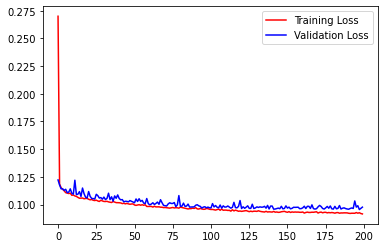

In [20]:
plt.plot(history1.history['loss'],color='r',label='Training Loss')
plt.plot(history1.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [21]:
predictions = model.predict([xtestScaled,testCat])
print(predictions.shape)

(2804, 3)


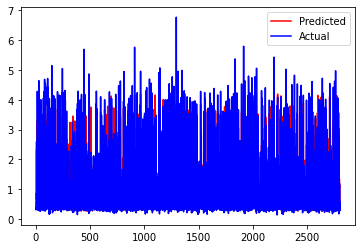

In [24]:
p=2
plt.plot(predictions[:,p],color='r',label='Predicted')
plt.plot(ytest[:,p],color='b',label='Actual')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error as mse,mean_absolute_error as mae,r2_score
import math

n=2
math.sqrt(mse(ytest[:,n],predictions[:,n]))*1000,r2_score(ytest[:,n],predictions[:,n])



(547.1431231603328, 0.7643950572011364)

In [126]:
## Since the data is sparse, transformation is required. 

veh1.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle
1,0.1,0.056133,872.34,0,0.000004,0.32878,Urban-Free
2,1.1,0.019722,871.085,0,0.000004,0.332906,Urban-Free
3,2.1,0.046526,868.51,0,0.000004,0.331826,Urban-Free
4,3.1,0.035399,874.915,0,0.000005,0.326944,Urban-Free
5,4.1,0.049053,866.438,0,0.000002,0.324458,Urban-Free


In [129]:
veh1['CO_Transformed'],coParam = stats.boxcox(veh1['CO Mass'].astype('float')+1)
veh1['NOx_Transformed'],noxParam = stats.boxcox(veh1['NOx Mass'].astype('float')+1)
veh1['CO2_Transformed'],co2Param = stats.boxcox(veh1['CO2 Mass'].astype('float')+1)

In [130]:
xtrain,xtest,ytrain,ytest = train_test_split(veh1[['Roll Speed','Eng. Speed','driving cycle ']].values,
                                            veh1[['CO_Transformed','NOx_Transformed','CO2_Transformed']].values, test_size=0.2,shuffle=True,random_state=42)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (11215, 3),xtest shape is (2804, 3)
ytrain shape is (11215, 3),ytest shape is (2804, 3)


based on the plot, the data is found to be sparse so, box cox tranformation is done to have a non-zero data

In [25]:
uFree['CO_Transformed'],coParam = stats.boxcox(uFree['CO Mass'])
uFree['NOx_Transformed'],noxParam = stats.boxcox(uFree['NOx Mass'])
uFree['CO2_Transformed'],co2Param = stats.boxcox(uFree['CO2 Mass'])

ValueError: Data must be positive.

In [140]:
comb = pd.concat([veh1.drop(['driving cycle '],axis=1),drivingCycles],axis=1)

In [92]:
comb.shape

(14019, 14)

In [93]:
comb.columns

Index(['Test Time', 'Roll Speed', 'CO Mass', 'NOx Mass', 'CO2 Mass',
       'Motorway-AM', 'Motorway-Free', 'Motorway-Inter', 'Suburban-Free',
       'Suburban-Inter', 'Urban- Inter', 'Urban-AM', 'Urban-Free',
       'suburban-AM'],
      dtype='object')

In [127]:
comb['CO Mass1'] = np.log(comb['CO Mass']+10)
comb['CO2 Mass'] = np.log(comb['CO2 Mass']+1)
comb['NOx Mass'] = np.log(comb['NOx Mass']+1)

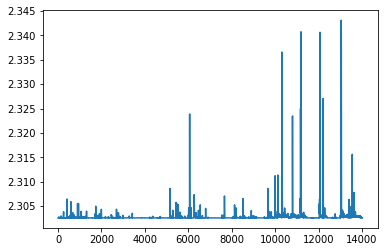

In [128]:
plt.plot(comb['CO Mass1'])

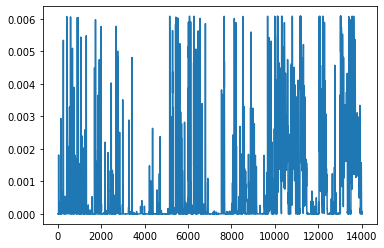

In [144]:
plt.plot(x)

In [143]:
from scipy import stats
x,_ = stats.boxcox(comb['CO Mass']+1)

In [125]:
comb['CO Mass']+10

1        10.000000
2        10.000000
3        10.000000
4        10.000000
5        10.000000
           ...    
14015    10.000004
14016    10.000004
14017    10.000004
14018    10.000002
14019    10.000001
Name: CO Mass, Length: 14019, dtype: float64

In [126]:
np.log(10)

2.302585092994046

<AxesSubplot:xlabel='Test Time'>

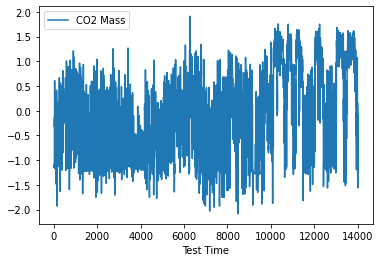

In [83]:
comb.plot(x='Test Time',y='CO2 Mass')

<AxesSubplot:xlabel='Test Time'>

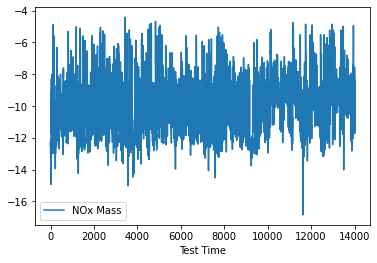

In [84]:
comb.plot(x='Test Time',y='NOx Mass')

In [130]:
xtrain,xtest,ytrain,ytest = train_test_split(comb.drop(['CO Mass', 'NOx Mass', 'CO2 Mass'],axis=1),comb[['CO Mass', 'NOx Mass', 'CO2 Mass']].values,shuffle=False,test_size=0.2)

In [131]:
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (11215, 11),xtest shape is (2804, 11)
ytrain shape is (11215, 3),ytest shape is (2804, 3)


In [132]:
scaler = MinMaxScaler()
scaler.fit(xtrain)
xtrainScaled = scaler.transform(xtrain)
xtestScaled = scaler.transform(xtest)

In [133]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

In [99]:
regressor = MultiOutputRegressor(SVR())
regressor.fit(xtrainScaled,ytrain)

MultiOutputRegressor(estimator=SVR())

In [101]:
regressor1 = DecisionTreeRegressor()
regressor1.fit(xtrainScaled,ytrain)

DecisionTreeRegressor()

In [100]:
regressor.score(xtrainScaled,ytrain)

-40.622011638789914

In [102]:
regressor1.score(xtrainScaled,ytrain)

1.0

In [103]:
predictions = regressor1.predict(xtestScaled)

In [104]:
predictions.shape

(2804, 3)

In [134]:
regressor2 = RandomForestRegressor()
regressor2.fit(xtrainScaled,ytrain)


RandomForestRegressor()

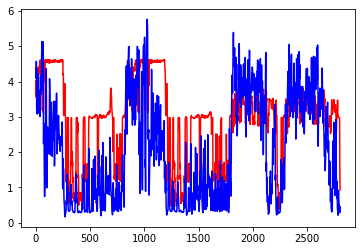

In [138]:
plt.plot(pred[:,2],color='r')
plt.plot(ytest[:,2],color='b')
plt.show()

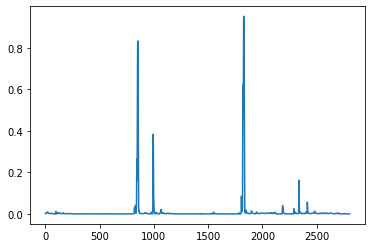

In [74]:
plt.plot(ytest[:,0])

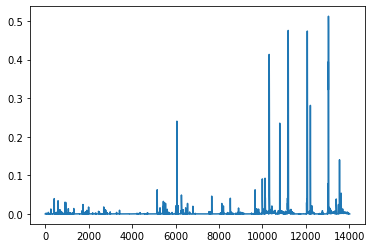

In [112]:
plt.plot(comb['CO Mass'])

In [90]:
np.log(0)

<ipython-input-90-f6e7c0610b57>:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [135]:
pred = regressor2.predict(xtestScaled)

In [139]:
regressor2.score(xtestScaled,ytest)

-4.050600769111223